In [1]:
import numpy as np
import sympy as sp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from dwave_qbsolv import QBSolv

Let's consider a fish population (Y, tones) model with harvesting rate (H, tones per year):

$\frac{d}{dt}Y = Y - 0.08 Y^2 - H$

In [2]:
def f(t, Y, H):
    return Y - 0.08 * Y * Y - H

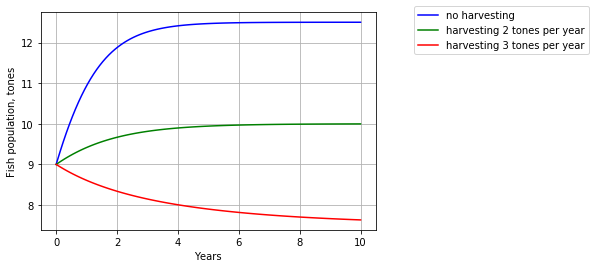

In [3]:
t = 10 # 10 years
y0 = 9 # initial population in tones

solution_rk1 = solve_ivp(lambda t, y: f(t, y, H=0), [0, t], [y0], max_step=0.1, method='RK23')
plt.plot(solution_rk1.t, solution_rk1.y[0,:], 'b-', label="no harvesting")

solution_rk2 = solve_ivp(lambda t, y: f(t, y, H=2), [0, t], [y0], max_step=0.1, method='RK23')
plt.plot(solution_rk2.t, solution_rk2.y[0,:], 'g-', label="harvesting 2 tones per year")

solution_rk3 = solve_ivp(lambda t, y: f(t, y, H=3), [0, t], [y0], max_step=0.1, method='RK23')
plt.plot(solution_rk3.t, solution_rk3.y[0,:], 'r-', label="harvesting 3 tones per year")

plt.xlabel('Years')
plt.ylabel('Fish population, tones')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid()

For simplicity let's consider differential equation in deviations from reference population that corresponds to H = 2:

$y' = -0.6y - 0.08 y^2 - 10h,$ where

$Y = y + 10$, $H = 10h+2$

For this equation one can build a matrix Lie map up to the necesary order of nonlinearuty. For example, the 3rd order map is:

$y = R_1\cdot(y_0, h) + R_2\cdot(y^2_0, y_0h, h^2) + R_3\cdot(y^3_0, y^2_0h, y_0h^2, h^3),$

where operation ($\cdot$) means dot product, and matrices $R_i$ represent map for 1 year interval:

In [4]:
R1 = np.array([0.54881164202246, -7.51980596629233])
R2 = np.array([-0.0330156535081131, 0.362975796701896, -1.49006845003106])
R3 = np.array([0.00198617090084235, -0.0283782220045298, 0.156860833432383, -0.373652148954954])

# apply map N times
def calc_map(Y0, H, N):
    y0 = Y0 - 10
    h = (H-2)/10
    y = np.empty(N+1)
    y[0] = y0
    for i in range(N):
        y0 = y[i]
        y[i+1] = np.dot(R1, np.array([y0, h])) + np.dot(R2, np.array([y0**2, y0*h, h**2])) + np.dot(R3, np.array([y0**3, y0**2*h, y0*h**2, h**3]))
    return y + 10

Now instead of step by step integration one can use nonlinear polynomial map for dynamics simulation.

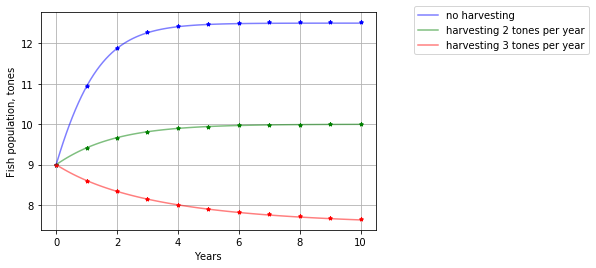

In [5]:
# calculate and plot dynamics via polynomial map:
solution = calc_map(Y0=9, H=0, N=10)
plt.plot(solution, 'b*', markersize=4)

solution = calc_map(Y0=9, H=2, N=10)
plt.plot(solution, 'g*', markersize=4)

solution = calc_map(Y0=9, H=3, N=10)
plt.plot(solution, 'r*', markersize=4)

# plot results from step by step integration
plt.plot(solution_rk1.t, solution_rk1.y[0,:], 'b-', alpha = 0.5, label="no harvesting")
plt.plot(solution_rk2.t, solution_rk2.y[0,:], 'g-', alpha = 0.5, label="harvesting 2 tones per year")
plt.plot(solution_rk3.t, solution_rk3.y[0,:], 'r-', alpha = 0.5, label="harvesting 3 tones per year")

plt.xlabel('Years')
plt.ylabel('Fish population, tones')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid()

Next let's formulate an optimization problem. For simplicity we will consider only first 2 years. With constant harvesting H = 2 tones per year one can obtain 4 tones of fish per 2 years with final population $Y(H_1=2, H_2=2, t=2)$. Assuming H as a control parameter that can be changed per year, we would like to find out optimal harvesting rates for the first ($H_1$) and second ($H_2$) years, such as

$H_1 + H_2 \rightarrow max$

$Y(H_1, H_2, t=2) \rightarrow Y(H_1=2, H_2=2, t=2)$

In other words, we aim to maximize harvesting with preservation of fish population in 2 years.

Y(H1=2, H2=2, t=2) = 9.667858834040405


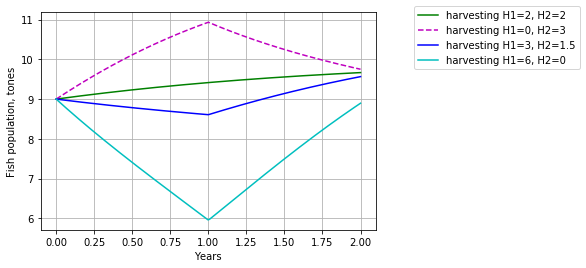

In [6]:
def f2(t, Y, H1, H2):
    H = 2 # reference
    if t<1:
        H = H1 # first year
    elif t<2:
        H = H2 # second year
    return Y - 0.08 * Y * Y - H

# constant harvesting each year:
solution_ref = solve_ivp(lambda t, y: f2(t, y, H1=2, H2=2), [0, 2], [y0], max_step=0.01, method='RK23')
plt.plot(solution_ref.t, solution_ref.y[0,:], 'g-', label="harvesting H1=2, H2=2")
Y_ref = solution_ref.y[0,-1]
print('Y(H1=2, H2=2, t=2) =', Y_ref)

# no harvesting during 1st year, H=3 for 2nd year:
solution_1 = solve_ivp(lambda t, y: f2(t, y, H1=0, H2=3), [0, 2], [y0], max_step=0.01, method='RK23')
plt.plot(solution_1.t, solution_1.y[0,:], 'm--', label="harvesting H1=0, H2=3")

# H=2 for 1st year, H=1.5 for 2nd year:
solution_2 = solve_ivp(lambda t, y: f2(t, y, H1=3, H2=1.5), [0, 2], [y0], max_step=0.01, method='RK23')
plt.plot(solution_2.t, solution_2.y[0,:], 'b-', label="harvesting H1=3, H2=1.5")

# H=6 for 1st year, H=0 for 2nd year:
solution_3 = solve_ivp(lambda t, y: f2(t, y, H1=6, H2=0), [0, 2], [y0], max_step=0.01, method='RK23')
plt.plot(solution_3.t, solution_3.y[0,:], 'c-', label="harvesting H1=6, H2=0")

plt.xlabel('Years')
plt.ylabel('Fish population, tones')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid()

Figure shows that optimal harvesting rates are lies between values:

$H_1 = 2, H_2 = 2$ and $H_1 = 6, H_2 = 0$.


Let's split this search space into discrete one:

$H_1 = 2 + 4*i/15$, $i = 1,2,\ldots15$

$H_2 = -2 + 2*i/15$, $i = 1,2,\ldots15$

This allow to encode harvesting rates $H_i = 10h_i+2$ by binary variables:

$h_1 = 0.4(\frac{1}{15}u_1 +\frac{2}{15}u_2 +\frac{4}{15}u_3 + \frac{8}{15}u_4), u_i \in \{0, 1\}$

$h_2 = -0.2(\frac{1}{15}v_1 +\frac{2}{15}v_2 +\frac{4}{15}v_3 + \frac{8}{15}v_4), v_i \in \{0, 1\}$

Instead of using brute force method with step by step integration, we can use described above polynomial map andL reformulate our optimization problems as QUBO. To begin with, one have to derive polynomial map for fish population in 2 years as a function of harvesting rates:

In [7]:
sp_y = sp.Symbol('y')
sp_h = sp.Symbol('h')

state1 = np.array([sp_y, sp_h])
state2 = np.array([sp_y**2, sp_y*sp_h, sp_h**2])
# state3 = np.array([sp_y**3, sp_y**2*sp_h, sp_y*sp_h**2, sp_h**3])

sp_y_map = np.dot(R1, state1) + np.dot(R2, state2)#+np.dot(R3, state3) # up to the second order

sp_y1 = sp_y_map.subs({sp_y: -1, sp_h: 'h1'}).expand() # fish population after 1st year
sp_y2 = sp_y_map.subs({sp_y: sp_y1, sp_h: 'h2'}).expand() # fish population after 2nd year

print('y(h1, h2, t=2) =',sp_y2)

y(h1, h2, t=2) = -0.0733047870771278*h1**4 - 0.775596099225794*h1**3 - 0.540858782790383*h1**2*h2 - 2.92654845579426*h1**2 - 2.86125899065001*h1*h2 - 4.62900955133537*h1 - 1.49006845003106*h2**2 - 7.73099519243045*h2 - 0.330490151566382


Now we have quadratic polynomial map for fish population $y(h_1, h_2, t=2)$ as a function of continious harvesting rates in the 1st ($h_1$) and 2nd ($h_2$) years. One can already use this map for search of optimal values in continious space $h_1 \in [0, 0.4], h_2 \in [-0.2, 0]$. On the other hand, one can introduce discrete binary variables as described above and use QUBO solver. 

In [8]:
# utils
# returns truncated polynom up to the quadratic terms
def truncate(expr):
    cdict = expr.expand().as_coefficients_dict()
    expr_trunc = eval_obj(expr, 0,0,0,0,   0,0,0,0)  
    for i in range(len(h_vars)):
        expr_trunc += h_vars[i]*cdict[h_vars[i]]
        for j in range(i+1, len(h_vars)):
            tmp = h_vars[i]*h_vars[j]
            expr_trunc+=tmp*cdict[tmp]
    return expr_trunc


# replace nonlinear terms of single variable by this variable (x**n = x if x in {0, 1})
def exclude_high_orders(expr, order=10):
    for tmp_u in h_vars:
        for i in list(range(2, order))[::-1]:
            expr = expr.subs(tmp_u**i, tmp_u)
    return expr

def eval_obj(obj, u1, u2, u3, u4, v1, v2, v3, v4):
    return obj.subs({sp_u1: u1, sp_u2: u2, sp_u3: u3, sp_u4: u4,
                     sp_v1: v1, sp_v2: v2, sp_v3: v3, sp_v4: v4})

Reformulation of $y(h_1, h_2, t=2)$ as function of binary variables $y(u_1, u_2, u_3, u_4, v_1, v_2, v_3, v_4, t=2)$

In [9]:
# descretization step:
h_step = 1/15

# binary variables:

# harvesting rate during the 1st year:
sp_u1 = sp.Symbol('u1')
sp_u2 = sp.Symbol('u2')
sp_u3 = sp.Symbol('u3')
sp_u4 = sp.Symbol('u4')
sp_h1 = (h_step*(sp_u1+2*sp_u2+4*sp_u3+8*sp_u4)).expand() # harvesting rate for the first year
sp_h1*=0.4 # h1 in [0, 0.4]  --> H1 = 10*h1 + 2 in [2, 6]

# harvesting rate during the 2nd year:
sp_v1 = sp.Symbol('v1')
sp_v2 = sp.Symbol('v2')
sp_v3 = sp.Symbol('v3')
sp_v4 = sp.Symbol('v4')
sp_h2 = (h_step*(sp_v1+2*sp_v2+4*sp_v3+8*sp_v4)).expand() # harvesting rate for the second year
sp_h2*=-0.2# h2 in [-0.2, 0] --> H2 = 10*h2 + 2 in [0, 2]

h_vars = [sp_u1, sp_u2, sp_u3, sp_u4, sp_v1, sp_v2, sp_v3, sp_v4]


obj = sp_y2.subs('h1', sp_h1).subs('h2', sp_h2).expand()
obj = exclude_high_orders(obj)
print(truncate(obj))

-0.00859151369465962*u1*u2 - 0.0175449062779704*u1*u3 - 0.0365657968662543*u1*u4 + 0.00102246467254201*u1*v1 + 0.00204492934508403*u1*v2 + 0.00408985869016806*u1*v3 + 0.00817971738033612*u1*v4 - 0.125536100495193*u1 - 0.0354534707418237*u2*u3 - 0.073873144482129*u2*u4 + 0.00205518563015028*u2*v1 + 0.00411037126030055*u2*v2 + 0.00822074252060111*u2*v3 + 0.0164414850412022*u2*v4 - 0.255323167800943*u2 - 0.150740960718448*u3*u4 + 0.00415139640056554*u3*v1 + 0.00830279280113108*u3*v2 + 0.0166055856022622*u3*v3 + 0.0332111712045243*u3*v4 - 0.528009412786914*u3 + 0.00846689336219104*u4*v1 + 0.0169337867243821*u4*v2 + 0.0338675734487642*u4*v3 + 0.0677351468975283*u4*v4 - 1.12839463417886*u4 - 0.0010596042311332*v1*v2 - 0.0021192084622664*v1*v3 - 0.00423841692453279*v1*v4 + 0.102815034841289*v1 - 0.00423841692453279*v2*v3 - 0.00847683384906559*v2*v4 + 0.205100267567012*v2 - 0.0169536676981312*v3*v4 + 0.408081326671758*v3 + 0.80768581949445*v4 - 0.330490151566382


This represents fish population in 2 years as function of binary variables:

$obj = obj(u_1, u_2, u_3, u_4, v_1, v_2, v_3, v_4) = y(h_1, h_2, t=2), u_i, v_i \in \{0, 1\}$.

Map $obj$ represent fish population at the end of the 2nd year as a function of harvesting rates encoded in binary forms with some descretization level.


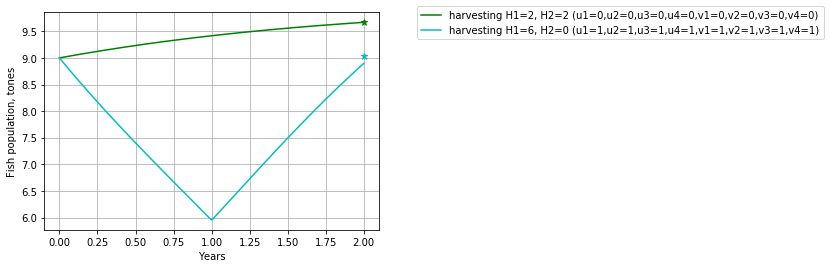

In [10]:
plt.plot(solution_ref.t, solution_ref.y[0,:], 'g-', label="harvesting H1=2, H2=2 (u1=0,u2=0,u3=0,u4=0,v1=0,v2=0,v3=0,v4=0)")
plt.plot(2, 10+eval_obj(obj, 0,0,0,0,  0,0,0,0), 'g*', markersize=7)


plt.plot(solution_3.t, solution_3.y[0,:], 'c-', label="harvesting H1=6, H2=0 (u1=1,u2=1,u3=1,u4=1,v1=1,v2=1,v3=1,v4=1)")
plt.plot(2, 10+eval_obj(obj, 1,1,1,1,  1,1,1,1), 'c*', markersize=7)


plt.xlabel('Years')
plt.ylabel('Fish population, tones')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid()

In the figure one can notice some errors due to the truncation up to the quadratic terms. Nevertheless we can utilize this quadratic approximation for optimization task. To build an objective function on have to calculate quadratic expression $obj2 = \left(y(h_1,h_2,t=2) - y(h_1=2,h_2=2,t=2)\right)^2$ that represents the displacement of fish population from reference value:

In [11]:
obj2 = (obj*obj).expand()
obj2 = obj2 - eval_obj(obj2, 0,0,0,0,  0,0,0,0)
obj2 = truncate(obj2)

Finaly, we can construct objective function for QUBO problem:

In [12]:
OBJ_POPULATION = obj2 # --> min (deviation of fish population from reference value (y(h1, h2, t=2)))
OBJ_HARVESTING = sp_u1 + sp_u2 + sp_u3 + sp_u4 + sp_v1 + sp_v2 + sp_v3 + sp_v4 # --> max (sum of harvesting rates)

OBJ = 10*OBJ_POPULATION - OBJ_HARVESTING

In [13]:
# build Q matrix from OBJ polynomial:
COEF = OBJ.as_coefficients_dict()

Q = {}
for i in range(len(h_vars)):
    Q[(i, i)] = COEF[h_vars[i]]
    for j in range(i+1, len(h_vars)):
        tmp = h_vars[i]*h_vars[j]
        Q[(i,j)] =COEF[tmp]
        
# solve QUBO:
response = QBSolv().sample_qubo(Q)
for d in list(response.samples()):
    print([d[key] for key in d])

[1, 1, 0, 1, 1, 1, 1, 1]


In [15]:
H1_opt = sp_h1.subs({sp_u1: 1, sp_u2: 1, sp_u3: 0, sp_u4: 1})*10+2
H2_opt = sp_h2.subs({sp_v1: 1, sp_v2: 1, sp_v3: 1, sp_v4: 1})*10+2

print('optimal H1 = ', H1_opt)
print('optimal H2 = ', H2_opt)

optimal H1 =  4.93333333333333
optimal H2 =  0


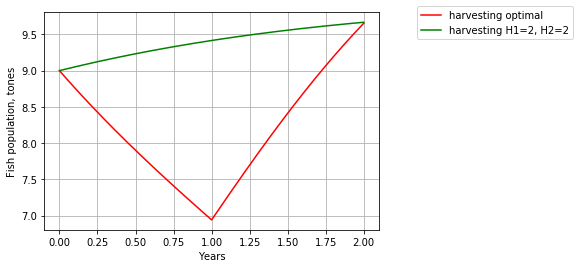

In [16]:
solution_opt = solve_ivp(lambda t, y: f2(t, y, H1=H1_opt, H2=H2_opt), [0, 2], [y0], max_step=0.01, method='RK23')
plt.plot(solution_opt.t, solution_opt.y[0,:], 'r-', label="harvesting optimal")

plt.plot(solution_ref.t, solution_ref.y[0,:], 'g-', label="harvesting H1=2, H2=2")
Y_ref = solution_ref.y[0,-1]

plt.xlabel('Years')
plt.ylabel('Fish population, tones')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid()

In [17]:
print("optimal harvesting: %s tones" % (H1_opt+H2_opt))
print("reference harvesting: 4 tones")

optimal harvesting: 4.93333333333333 tones
reference harvesting: 4 tones
